---------------------
# Example G.1.3

$$
y = \frac{\sin(2x)}{\exp(-x/5)}
$$

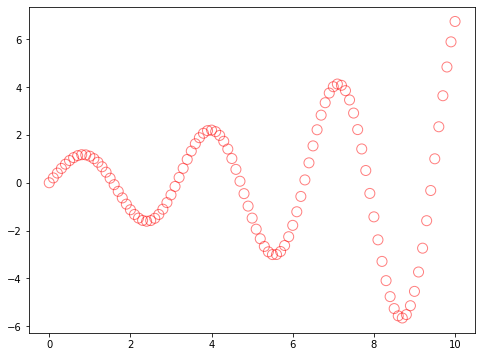

In [1]:
import matplotlib.pyplot as plt
import numpy as np

X = np.arange(0,10.1,0.1)
Y = np.sin(2*X)/np.exp(-X/5.)
data_trn = np.hstack((X.reshape((-1,1)),Y.reshape((-1,1))))

# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  
fig = plt.figure(figsize=(8,6))
plt.scatter(X,Y,s=100,fc="none",ec="red",alpha=0.5)
plt.show()

EPOCH: 50 	 TRAINING ERROR: 0.259

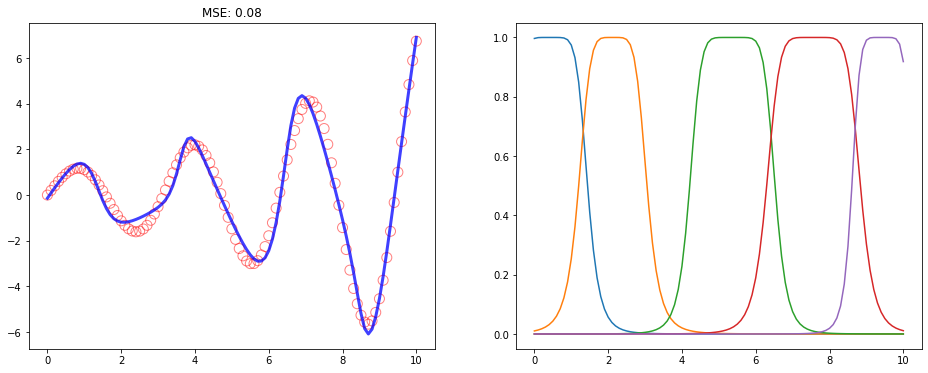

In [2]:
class ANFIS(object):
    def __init__(self,):
        self.eta = 0.01
        self.bsize = 1
        self.nepochs = 50

        self.a = np.array([0.,2.5,5.,7.5,10.])
        self.b = np.array([1.,1.,1.,1.,1.])
        self.c = np.array([3.,3.,3.,3.,3.])
        self.nb = len(self.a)

        self.f = self.GBell
        self.df = self.dGBell
        self.cost = self.MSE

    def loading_data(self,X,Y):
        self.data_trn = np.hstack((X.reshape((-1,1)),Y.reshape((-1,1))))

    def GBell(self,x,a,b,c):
        y = abs((x-a)/b)
        z = y**(2*c)
        gbell = 1/(1+z)
        return gbell

    def dGBell(self,x,a,b,c):
        y = abs((x-a)/b)
        z = y**(2*c)
        dGBz = -1/(1+z)**2
        dZc = 2*y**(2*c)*np.log(y)
        dZy = 2*c*y**(2*c-1)
        dYa = (a-x)/b**2/abs((a-x)/b)
        dYb = -(a-x)**2/b**3/abs((a-x)/b)
        dGBa = dYa*dZy*dGBz
        dGBb = dYb*dZy*dGBz
        dGBc = dZc*dGBz
        return dGBa,dGBb,dGBc

    def predict(self,x):
        W = np.array([])
        for a,b,c in zip(self.a,self.b,self.c):
            W = np.append(W,self.f(x,a,b,c))
        WS = W.sum()
        WB = W/WS
        F = np.array([])
        for p,q in zip(self.p,self.q):
            F = np.append(F,p*x+q)
        return WB@F

    def MSE(self,x=None,y=None):
        if (x is None) and (y is None):
            x = self.data_trn[:,0]
            y = self.data_trn[:,1]
        yp = np.array([self.predict(xi) for xi in x])
        MSE = np.mean(0.5*(yp-y)**2)
        return MSE  

    def MFs(self,X=None):
        if X is None:
            X = self.data_trn[:,0]
        MFs = []
        for a,b,c in zip(self.a,self.b,self.c):
            MF = []
            for x in X:
                MF.append(self.f(x,a,b,c))
            MFs.append(MF)
        return np.array(MFs)

    def gradients(self,x,y):
        W = np.array([])
        dWabc = np.array([])
        for a,b,c in zip(self.a,self.b,self.c):
            W = np.append(W,self.f(x,a,b,c))
            dWabc = np.append(dWabc,self.df(x,a,b,c))
        dWabc = dWabc.reshape((-1,3))
        WS = W.sum()
        WB = W/WS
        F = np.array([])
        for p,q in zip(self.p,self.q):
            F = np.append(F,p*x+q)
        yp = WB@F
        dEy = yp - y
        dEp = dEy*WB*x
        dEq = dEy*WB
        dYw = (F-yp)/WS
        dEa = dEy*dYw*dWabc[:,0]
        dEb = dEy*dYw*dWabc[:,1]
        dEc = dEy*dYw*dWabc[:,2]
        return dEa,dEb,dEc,dEp,dEq
    
    def GD(self,):
        n = self.data_trn.shape[0]
        for epoch in range(self.nepochs):
            data_trn = self.data_trn.copy()
            np.random.shuffle(data_trn)
            for i in range(0,n,self.bsize):
                data_batch = data_trn[i:i+self.bsize]
                dEa,dEb,dEc,dEp,dEq = 0.,0.,0.,0.,0.
                for x,y in zip(data_batch[:,0],data_batch[:,1]):
                    dEa_,dEb_,dEc_,dEp_,dEq_ = self.gradients(x,y)
                    dEa += dEa_
                    dEb += dEb_
                    dEc += dEc_
                bsize = data_batch.shape[0]
                self.a -= self.eta/bsize * dEa
                self.b -= self.eta/bsize * dEb
                self.c -= self.eta/bsize * dEc
            training_error = self.MSE().round(3)
            print(f"\rEPOCH: {epoch+1} \t TRAINING ERROR: {training_error}",end="")
    
    def LSE(self,):
        X = self.data_trn[:,0]
        Y = self.data_trn[:,1]        
        W = self.MFs(X)
        WS = np.sum(W,axis=0)
        WB = W/WS.reshape((1,-1))
        WX = WB*X.reshape((1,-1))
        XT = np.vstack((WX,WB)).T
        PQ = np.linalg.inv(XT.T@XT)@XT.T@Y
        self.p = PQ[0:5]
        self.q = PQ[5:]

### MAIN ###
anf = ANFIS()
anf.loading_data(X,Y)
anf.eta = 0.01
anf.nepochs = 50
anf.LSE()
anf.GD()
anf.LSE()

### PLOT ###
fig,ax = plt.subplots(1,2,figsize=(16,6))

Yp = np.array([anf.predict(x) for x in X])
ax[0].scatter(X,Y,s=100,fc="none",ec="red",alpha=0.5)
ax[0].set_title(f"MSE: {anf.MSE().round(2)}")
ax[0].plot(X,Yp,"b",lw=3,alpha=0.75)

MFs = anf.MFs()
for MF in MFs:
    ax[1].plot(X,MF)
plt.show()

------------------------
# Example SINC

Simulation for 
$$
z = \text{sinc}(x,y) = \frac{\sin(x)\sin(y)}{xy}
$$

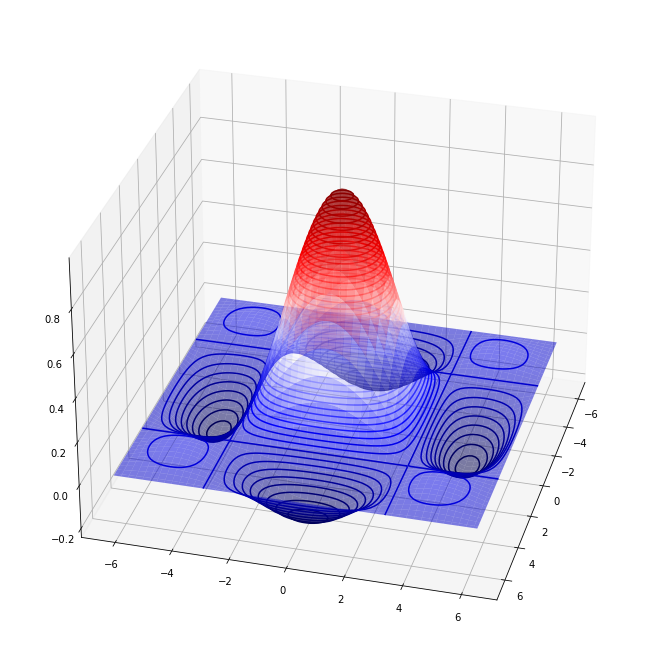

In [3]:
import matplotlib.pyplot as plt
import numpy as np

n = 1200

X = np.random.uniform(-2*np.pi,2*np.pi,n)
Y = np.random.uniform(-2*np.pi,2*np.pi,n)
Z = np.sin(X)*np.sin(Y)/(X*Y)
data_trn = np.hstack((X.reshape((-1,1)),Y.reshape((-1,1)),Z.reshape((-1,1))))

n = 100
X = np.linspace(-2*np.pi,2*np.pi,n)
Y = np.linspace(-2*np.pi,2*np.pi,n)
XX,YY = np.meshgrid(X,Y)
ZZ = np.sin(XX)*np.sin(YY)/(XX*YY)
data_tst = np.hstack((XX.reshape((-1,1)),YY.reshape((-1,1)),ZZ.reshape((-1,1))))

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  
fig = plt.figure(figsize=(16,12))
ax = plt.axes(projection='3d')
ax.contour3D(XX,YY,ZZ,50,cmap='seismic')
ax.plot_surface(XX,YY,ZZ,alpha=0.5,cmap='seismic')
ax.view_init(30,15)
plt.show()

In [14]:
class ANFIS(object):
    def __init__(self,):
        self.nb = 12
        self.eta = 0.1
        self.bsize = 10
        self.nepochs = 24
        self.mux = np.random.randn(self.nb)
        self.sigx = 2.0*abs(np.random.randn(self.nb))
        self.muy = np.random.randn(self.nb)
        self.sigy = 2.0*abs(np.random.randn(self.nb))
        self.a = np.random.randn(self.nb,self.nb)
        self.b = np.random.randn(self.nb,self.nb)
        self.c = np.random.randn(self.nb,self.nb)

    def f(self,xy):
        x,y = xy
        return self.a*x + self.b*y + self.c 

    def gauss(self,x,mu,sig):
        return np.exp(-((x-mu)/sig)**2/2)

    def w(self,xy):
        x,y = xy
        w = np.zeros((self.nb,self.nb))
        for i in range(self.nb):
            for j in range(self.nb):
                w[i,j] = self.gauss(x,self.mux[i],self.sigx[i]) * self.gauss(y,self.muy[j],self.sigy[j])
        return w

    def predict(self,xy):
        w = self.w(xy)
        wsum = np.sum(w)
        f = self.f(xy)
        zp = w * f / wsum
        zp = zp.sum()
        return zp

    def error(self,xy,z):
        zp = self.predict(xy)
        return 0.5*(zp-z)**2

    def gradient(self,xy,z):
        x,y = xy
        w = self.w(xy)
        wsum = np.sum(w)
        f = self.f(xy)
        zp = w * f / wsum
        zp = zp.sum()
        gEz = zp - z

        gEa = gEz*w*x
        gEb = gEz*w*y
        gEc = gEz*w

        gZw = (f-zp)/wsum
        gEmux = np.zeros(self.nb)
        gEmuy = np.zeros(self.nb)
        gEsigx = np.zeros(self.nb)
        gEsigy = np.zeros(self.nb)
        for i in range(self.nb):
            gEmux[i] = np.sum([gEz*gZw[i,j]*((x-self.mux[i])/self.sigx[i]**2)*w[i,j] for j in range(self.nb)])
            gEsigx[i] = np.sum([gEz*gZw[i,j]*((x-self.mux[i])**2/self.sigx[i]**3)*w[i,j] for j in range(self.nb)])
            gEmuy[i] = np.sum([gEz*gZw[j,i]*((x-self.muy[i])/self.sigy[i]**2)*w[j,i] for j in range(self.nb)])
            gEsigy[i] = np.sum([gEz*gZw[j,i]*((x-self.muy[i])**2/self.sigy[i]**3)*w[j,i] for j in range(self.nb)])
        
        return gEa,gEb,gEc,gEmux,gEsigx,gEmuy,gEsigy
        
    def data_loading(self,):
        self.data_trn = data_trn
        self.data_tst = data_tst
    
    def GD(self,):
        n = self.data_trn.shape[0]
        for epoch in range(self.nepochs):
            np.random.shuffle(self.data_trn)
            for i in range(0,n,self.bsize):
                data_batch = self.data_trn[i:i+self.bsize]
                gEa,gEb,gEc,gEmux,gEsigx,gEmuy,gEsigy = 0.,0.,0.,0.,0.,0.,0.
                for xy,z in zip(data_batch[:,:2],data_batch[:,2]):
                    gEa_,gEb_,gEc_,gEmux_,gEsigx_,gEmuy_,gEsigy_ = self.gradient(xy,z)
                    gEa += gEa_
                    gEb += gEb_
                    gEc += gEc_
                    gEmux += gEmux_
                    gEsigx += gEsigx_
                    gEmuy += gEmuy_
                    gEsigy += gEsigy_

                self.a -= self.eta/data_batch.shape[0] * gEa
                self.b -= self.eta/data_batch.shape[0] * gEb
                self.c -= self.eta/data_batch.shape[0] * gEc

                self.mux -= self.eta/data_batch.shape[0] * gEmux
                self.muy -= self.eta/data_batch.shape[0] * gEmuy
                self.sigx -= self.eta/data_batch.shape[0] * gEsigx
                self.sigy -= self.eta/data_batch.shape[0] * gEsigy

            training_error = np.mean([self.error(i,j) for i,j in zip(self.data_trn[:,:2],self.data_trn[:,2])]).round(3)
            testing_error = np.mean([self.error(i,j) for i,j in zip(self.data_tst[:,:2],self.data_tst[:,2])]).round(3)
            print(f"\rEPOCH: {epoch+1} \t TRAINING ERROR: {training_error} \t TESTING ERROR: {testing_error}",end="")

anfis = ANFIS()
anfis.data_loading()
anfis.GD()

EPOCH: 24 	 TRAINING ERROR: 0.007 	 TESTING ERROR: 0.008

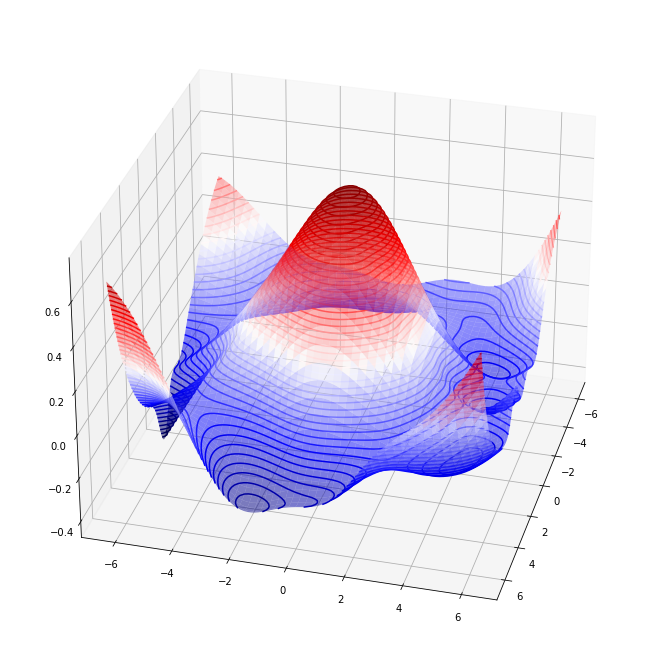

In [15]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  
n = 100
X = np.linspace(-2*np.pi,2*np.pi,n)
Y = np.linspace(-2*np.pi,2*np.pi,n)
XX,YY = np.meshgrid(X,Y)
ZZp = np.zeros_like(XX)
for i in range(n):
    for j in range(n):
        ZZp[i,j] = anfis.predict((XX[i,j],YY[i,j]))

fig = plt.figure(figsize=(16,12))
ax = plt.axes(projection='3d')
# ax.plot_surface(XX,YY,ZZ,alpha=0.5,cmap='seismic')
ax.contour3D(XX,YY,ZZp,50,cmap='seismic')
ax.plot_surface(XX,YY,ZZp,alpha=0.5,cmap='seismic')
ax.view_init(30,15)
plt.show()